# Zindi Data Science Challenge: Agricultural Keyword Spotter: Training

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tifffile

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models

import random
SEED_VAL = 42
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys  
sys.path.insert(0, './utils')

from preprocess import *
from training import *

## Building the Dataset

First, I import the CSV file I have saved, containing the names of every audio file and correpsonding label and TIF image.

In [11]:
train_paths = pd.read_csv('train_paths.csv').drop(columns=['Unnamed: 0'])

In [12]:
train_paths.sample(5)

,fn,image,label,label_num
1210,./nlp_keywords/ebisooli/d027264654b94950aeb204...,d027264654b94950aeb204f64d05d8d7_ff223fec3f304...,ebisooli,116
1729,./nlp_keywords/okusimba/d027264654b94950aeb204...,d027264654b94950aeb204f64d05d8d7_7e2741dcaed34...,okusimba,146
3321,./latest_keywords/nnimiro/eb702740d41f4f389192...,eb702740d41f4f389192ec5c6a3ae95f_e0f8397388b94...,nnimiro,73
3722,./latest_keywords/ekikajjo/771b5044334242fb9ca...,771b5044334242fb9caff8a71fd7891e_8006801f701e4...,ekikajjo,86
3752,./latest_keywords/ebigimusa/3d43af6faf2244c288...,3d43af6faf2244c288154dc4ff6a734f_8b843bfe8a804...,ebigimusa,11


Next, I split the examples into training and validation set and make sure, that the classes are equally distributed in both sets, given how few examples many classes have.

In [23]:
X_train, X_val, y_train, y_val = train_test_split(train_paths['image'], train_paths['label_num'], stratify=train_paths['label_num'], test_size=0.2, random_state=SEED_VAL)

Finally, I create a training Dataset (which includes data augmentation with SpecAugment) and a validation Dataset .

In [24]:
train_ds = Spectrogram_Dataset_Augmentation(X_train.values, y_train.values, augment=True)
val_ds = Spectrogram_Dataset_Augmentation(X_val.values, y_val.values, augment=False)

## Training

After doing some research about using CNNs for audio classification, I saw that using a transfer learning approach with CNNs pretrained on ImageNet works quite well for mel spectrograms (see, for example, https://medium.com/@krishna_84429/audio-classification-using-transfer-learning-approach-912e6f7397bb and https://arxiv.org/pdf/2007.11154.pdf). 

After some experiments involving multiple pretrained models in torchvision, using `densenet161`, `resnet50`, and  `googlenet` yielded the best validation performance. In order to perform transfer learning with them, I removed the last linear layer of all three models and replaced it with a new one which had an output dimension of 193 (i.e. the number of unique classes in this challenge).

The plan is to ensemble those three models in order to improve the model's ability to generalize.

### Densenet

In [27]:
densenet = models.densenet161(pretrained=True)
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, 193)
densenet = densenet.to(device)

Ep: 1/100 | Train Loss: 5.0285 | Val Loss: 6.4820 | Val Acc: 0.0212
Validation accuracy has improved from 0.0000 to 0.0212. Saving model...
Ep: 2/100 | Train Loss: 4.0494 | Val Loss: 3.6722 | Val Acc: 0.1614
Validation accuracy has improved from 0.0212 to 0.1614. Saving model...
Ep: 3/100 | Train Loss: 2.9732 | Val Loss: 3.1951 | Val Acc: 0.2357
Validation accuracy has improved from 0.1614 to 0.2357. Saving model...
Ep: 4/100 | Train Loss: 2.2932 | Val Loss: 2.9537 | Val Acc: 0.2845
Validation accuracy has improved from 0.2357 to 0.2845. Saving model...
Ep: 5/100 | Train Loss: 1.9057 | Val Loss: 2.7832 | Val Acc: 0.3195
Validation accuracy has improved from 0.2845 to 0.3195. Saving model...
Ep: 6/100 | Train Loss: 1.6999 | Val Loss: 1.7661 | Val Acc: 0.5340
Validation accuracy has improved from 0.3195 to 0.5340. Saving model...
Ep: 7/100 | Train Loss: 1.5419 | Val Loss: 1.3766 | Val Acc: 0.6316
Validation accuracy has improved from 0.5340 to 0.6316. Saving model...
Ep: 8/100 | Train Lo

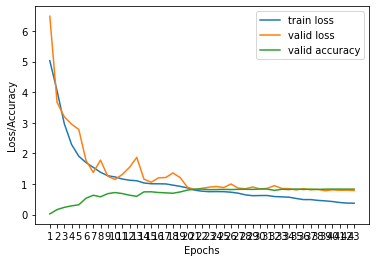

In [28]:
train_epoch_loss, valid_epoch_loss, acc_epoch = train_model_finetuning(densenet, 'densenet', train_ds, val_ds, batch_size=128, num_epochs=100, device=device, save_model=True, early_stopping_patience=8)

### Resnet

In [29]:
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 193)
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Ep: 1/100 | Train Loss: 5.1883 | Val Loss: 5.1757 | Val Acc: 0.0127
Validation accuracy has improved from 0.0000 to 0.0127. Saving model...
Ep: 2/100 | Train Loss: 4.8179 | Val Loss: 8.8175 | Val Acc: 0.0223
Validation accuracy has improved from 0.0127 to 0.0223. Saving model...
Ep: 3/100 | Train Loss: 4.3742 | Val Loss: 7.4980 | Val Acc: 0.0159
Ep: 4/100 | Train Loss: 3.8957 | Val Loss: 5.0987 | Val Acc: 0.0807
Validation accuracy has improved from 0.0223 to 0.0807. Saving model...
Ep: 5/100 | Train Loss: 3.4262 | Val Loss: 3.5351 | Val Acc: 0.1263
Validation accuracy has improved from 0.0807 to 0.1263. Saving model...
Ep: 6/100 | Train Loss: 3.0518 | Val Loss: 3.5650 | Val Acc: 0.1815
Validation accuracy has improved from 0.1263 to 0.1815. Saving model...
Ep: 7/100 | Train Loss: 2.7036 | Val Loss: 2.9449 | Val Acc: 0.2569
Validation accuracy has improved from 0.1815 to 0.2569. Saving model...
Ep: 8/100 | Train Loss: 2.4078 | Val Loss: 2.8338 | Val Acc: 0.2527
Ep: 9/100 | Train Loss: 

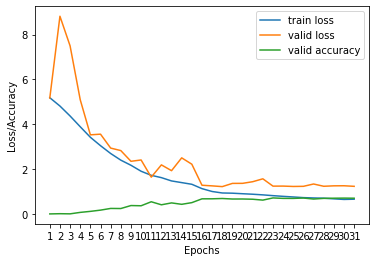

In [30]:
train_epoch_loss, valid_epoch_loss, acc_epoch = train_model_finetuning(resnet, 'resnet', train_ds, val_ds, batch_size=128, num_epochs=100, device=device, save_model=True, early_stopping_patience=8)

### GoogLeNet

In [33]:
googlenet = models.googlenet(pretrained=True)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 193)
googlenet = googlenet.to(device)

Ep: 1/100 | Train Loss: 5.0259 | Val Loss: 4.6311 | Val Acc: 0.0456
Validation accuracy has improved from 0.0000 to 0.0456. Saving model...
Ep: 2/100 | Train Loss: 3.8988 | Val Loss: 3.0630 | Val Acc: 0.2622
Validation accuracy has improved from 0.0456 to 0.2622. Saving model...
Ep: 3/100 | Train Loss: 2.8262 | Val Loss: 2.7685 | Val Acc: 0.2803
Validation accuracy has improved from 0.2622 to 0.2803. Saving model...
Ep: 4/100 | Train Loss: 2.2514 | Val Loss: 1.9057 | Val Acc: 0.5021
Validation accuracy has improved from 0.2803 to 0.5021. Saving model...
Ep: 5/100 | Train Loss: 1.8876 | Val Loss: 2.1355 | Val Acc: 0.4469
Ep: 6/100 | Train Loss: 1.6733 | Val Loss: 1.6179 | Val Acc: 0.5711
Validation accuracy has improved from 0.5021 to 0.5711. Saving model...
Ep: 7/100 | Train Loss: 1.5068 | Val Loss: 1.5447 | Val Acc: 0.5902
Validation accuracy has improved from 0.5711 to 0.5902. Saving model...
Ep: 8/100 | Train Loss: 1.3949 | Val Loss: 1.6352 | Val Acc: 0.5616
Ep: 9/100 | Train Loss: 

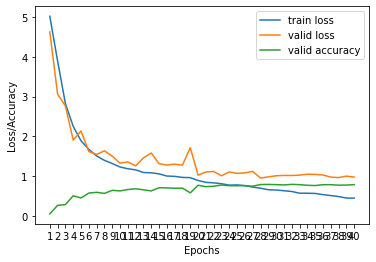

In [34]:
train_epoch_loss, valid_epoch_loss, acc_epoch = train_model_finetuning(googlenet, 'googlenet', train_ds, val_ds, batch_size=128, num_epochs=100, device=device, save_model=True, early_stopping_patience=8)